In [15]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import aslinearoperator, eigs
from scipy.sparse import diags
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import reduced_rank_regression
from DynamicalSystems.utils import plot_eigs
import seaborn as sns
def implied_timescale(eigenvalues, stride, timestep):
    return (stride*timestep)/np.log(eigenvalues)

#### Standardizing dataset

In [34]:
df_pd = pd.read_pickle("full_dataframe").interpolate()
#Get stations and measurements 
stations = set()
measurements = set()
for col in df_pd.columns:
    meas, stat = col.split("_")
    measurements.add(meas)
    stations.add(stat)

standardizing_parameters = dict() # (std, mean)

for m in measurements:
    std = df_pd.filter(regex= m + "_*").std().mean()
    mean = df_pd.filter(regex= m + "_*").mean().mean()
    standardizing_parameters[m] = (std, mean)
    df_pd[df_pd.filter(regex= m + "_*").columns] -= mean
    df_pd[df_pd.filter(regex= m + "_*").columns] /= std
df = df_pd.filter(regex= "DEWP*").to_numpy()
#df = df_pd.to_numpy()

#### Selecting timestep, kernel, desired rank & regularizer

In [35]:
def subsample_data(df, n_timesteps, full_data=True):
    """Subsample the dataframe every timestep

    Args:
        df (np.ndarray): dataframe
        n_timesteps (int): number of original timesteps to skip because of subsamplign
        full_data (bool, optional): Retain full data or subsample only one of the possible n_timesteps subsequences. Defaults to True.
    """
    nan_mask = np.isnan(df).any(axis=1)
    dataset_indexes = []
    if full_data:
        for idx, val in enumerate(nan_mask[:-n_timesteps]):
            if val == False:
                if nan_mask[idx + n_timesteps] == False:
                    dataset_indexes.append((idx, idx+ n_timesteps))
    else:
        for idx, val in enumerate(nan_mask[::n_timesteps][:-1]):
            if val == False:
                if nan_mask[::n_timesteps][idx + 1] == False:
                    dataset_indexes.append((idx*n_timesteps, (idx+1)*n_timesteps))
    dataset_indexes = np.array(dataset_indexes)
    inputs = df[dataset_indexes[:,0]]
    evolved_inputs = df[dataset_indexes[:,1]]
    return inputs, evolved_inputs

In [40]:
n_timesteps = 24*30 #In hours
rank = 10
regularizer = 1e-2
l = np.float32(np.sqrt(df.shape[1]))
X, Y = subsample_data(df, n_timesteps, full_data=True)
nu = 1.5
kernel = Matern(nu = nu, length_scale=l)

In [41]:
df.shape

(35064, 12)

In [42]:
evals, evecs = reduced_rank_regression(X, Y, kernel, rank, regularizer=regularizer)

Low rank projection
Final diagonalization


Solving CG iteration: 100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


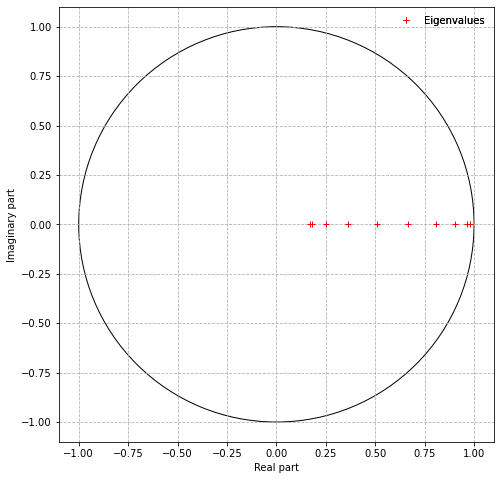

In [38]:
plot_eigs(evals)

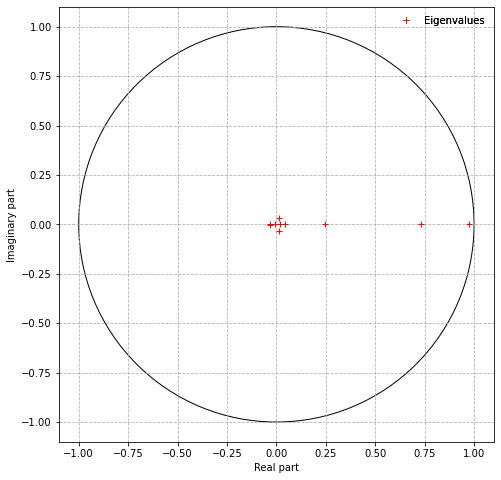

In [43]:
plot_eigs(evals)

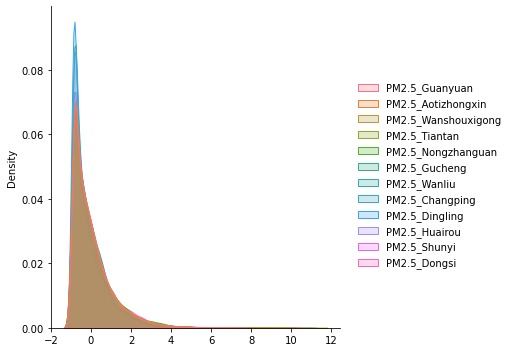

In [109]:
import seaborn as sns
ax = sns.displot(df_pd.filter(regex="PM2.5_*"), kind='kde', fill=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


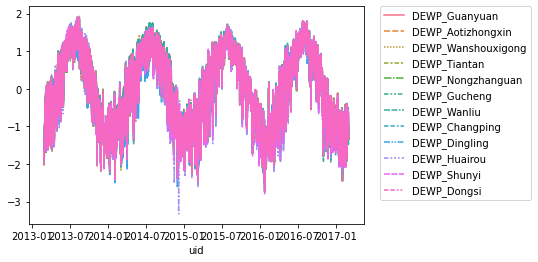

In [16]:
pm25_df = df_pd.filter(regex= "DEWP*")
ax = sns.lineplot(data=pm25_df, ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/tmp/ipykernel_1454261/3063865643.py:15: RuntimeWarning: divide by zero encountered in true_divide
  t_h = 1/f_oneside / (60 * 60)


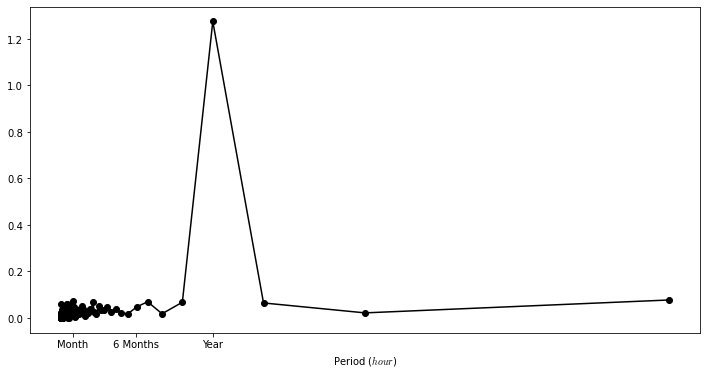

In [30]:
from scipy.fftpack import fft, ifft
X = fft(pm25_df["DEWP_Guanyuan"].to_numpy())
N = len(X)
n = np.arange(N)
# get the sampling rate
sr = 1 / (60*60)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]
# convert frequency to hour
t_h = 1/f_oneside / (60 * 60)

plt.figure(figsize=(12,6))
plt.plot(t_h, np.abs(X[:n_oneside])/n_oneside, 'ko-')
plt.xticks([24*30, 24*30*6, 24*365], ["Month", "6 Months", "Year"])
plt.xlabel('Period ($hour$)')
plt.show()

array([-1.54368267, -1.50016273, -1.50016273, ..., -1.14474992,
       -1.11573663, -1.33333631])